In [1]:
import pandas as pd 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import roc_auc_score, roc_curve
import scipy.stats as stats
import pickle
from scipy.stats import wilcoxon, spearmanr

sys.path.append("/home/evos/extra_code/analysis_kather")

from kather_analysis_function import AUC_kather
from sklearn.linear_model import LinearRegression

In [2]:
#Load all results 
predictions_dir_lasso = "/home/evos/Outputs/CRC/Orion/3_tile_level_quantification_macenko/test_tile_predictions_proba_macenko.csv"
predictions_dir_MIL = "/home/evos/Outputs/CRC/Orion/MIL_results/MIL_final_pcchip/all_cell_types.csv"

predictions_lasso = pd.read_csv(predictions_dir_lasso, sep="\t")
predictions_MIL = pd.read_csv(predictions_dir_MIL, sep=",")

print(predictions_lasso.columns)
print(predictions_MIL.columns)

Index(['CAFs', 'T_cells', 'endothelial_cells', 'tumor_purity', 'Coord_X',
       'Coord_Y', 'tile_ID', 'slide_id'],
      dtype='object')
Index(['tile_ID', 'tumor_purity', 'slide_id', 'Coord_X', 'Coord_Y', 'T_cells',
       'endothelial_cells'],
      dtype='object')


In [12]:
all_results_RMTLR_tumor = AUC_kather(predictions_lasso, 'tumor_purity', 'TUM')
all_results_MIL_tumor = AUC_kather(predictions_MIL, 'tumor_purity', 'TUM')

all_results_RMTLR_Tcells = AUC_kather(predictions_lasso, 'T_cells', 'LYM')
all_results_MIL_Tcells = AUC_kather(predictions_MIL, 'T_cells', 'LYM')

Average AUC over all slides: 0.5389
Combined AUC = 0.6118
Finished kather analysis


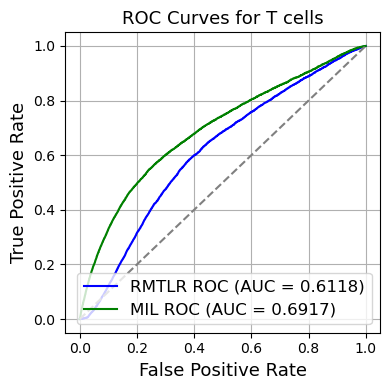

In [47]:
# Compute ROC for LASSO data
output_dir_plot = "/home/evos/figures/figures_lasso_vs_MIL"

combined_labels_lasso = all_results_RMTLR_Tcells['all_labels_probs'][0]
combined_probs_lasso = all_results_RMTLR_Tcells['all_labels_probs'][1]

fpr_lasso, tpr_lasso, _ = roc_curve(combined_labels_lasso, combined_probs_lasso)
auc_lasso = roc_auc_score(combined_labels_lasso, combined_probs_lasso)

# Prepare MIL data
combined_labels_MIL = all_results_MIL_Tcells['all_labels_probs'][0]
combined_probs_MIL =  all_results_MIL_Tcells['all_labels_probs'][1]

# Compute ROC for MIL data
fpr_MIL, tpr_MIL, _ = roc_curve(combined_labels_MIL, combined_probs_MIL)
auc_MIL = roc_auc_score(combined_labels_MIL, combined_probs_MIL)

# Plot both ROC curves
plt.figure(figsize=(4, 4))
plt.plot(fpr_lasso, tpr_lasso, color='blue', label=f'RMTLR ROC (AUC = {auc_lasso:.4f})')
plt.plot(fpr_MIL, tpr_MIL, color='green', label=f'MIL ROC (AUC = {auc_MIL:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random performance
plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.title(f'ROC Curves for T cells', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.tight_layout()

plt.savefig(f"{output_dir_plot}/ROC_curve_T.png", dpi=300) 
plt.show()
plt.close() 

Group: Tumor
Spearman's ρ: 0.259
p-value: 1.015e-01
Group: T-cells
Spearman's ρ: 0.805
p-value: 2.189e-10


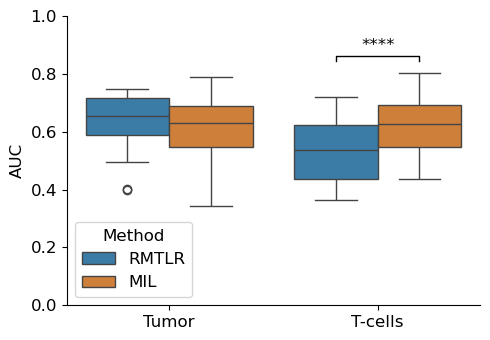

In [39]:
output_dir_plot = "/home/evos/figures/figures_lasso_vs_MIL"

all_AUCs_RMTLR_tumor = all_results_RMTLR_tumor['AUC_values']
all_AUCs_MIL_tumor = all_results_MIL_tumor['AUC_values']

all_AUCs_RMTLR_T = all_results_RMTLR_Tcells['AUC_values']
all_AUCs_MIL_T = all_results_MIL_Tcells['AUC_values']

# Prepare data
all_data = []

data_sources = [
    ("Tumor", "RMTLR", all_AUCs_RMTLR_tumor),
    ("Tumor", "MIL", all_AUCs_MIL_tumor),
    ("T-cells", "RMTLR", all_AUCs_RMTLR_T),
    ("T-cells", "MIL", all_AUCs_MIL_T)
]

for cell_type, method, scores_dict in data_sources:
    for slide_id, auc_value in scores_dict.items():
        all_data.append([auc_value, method, cell_type, slide_id])

# Convert to DataFrame
df = pd.DataFrame(all_data, columns=["AUC", "Method", "Cell Type", "Slide_ID"])

group_pairs = [
    ("Tumor", all_AUCs_RMTLR_tumor, all_AUCs_MIL_tumor),
    ("T-cells", all_AUCs_RMTLR_T, all_AUCs_MIL_T)
]

p_values = {}
group_max_values = {}

# Calculate p-values and group-wise maximums
for group, rmtlr_dict, mil_dict in group_pairs:
    common_keys = set(rmtlr_dict.keys()) & set(mil_dict.keys())
    rmtlr_values = [rmtlr_dict[k] for k in common_keys]
    mil_values = [mil_dict[k] for k in common_keys]
    
    if rmtlr_values and mil_values:
        _, p = wilcoxon(rmtlr_values, mil_values, alternative='two-sided')
        p_values[group] = p
        rho, p_corr = spearmanr(rmtlr_values, mil_values)
        print(f"Group: {group}\nSpearman's ρ: {rho:.3f}\np-value: {p_corr:.3e}")
        group_max_values[group] = max(rmtlr_values + mil_values)

# Set color palette
palette = {"RMTLR": "#2980b9", "MIL": "#e67e22"}

plt.figure(figsize=(5, 3.5))
sns.boxplot(x='Cell Type', y='AUC', hue='Method', data=df, palette=palette)

# Add significance markers
for i, (group, p_value) in enumerate(p_values.items()):
    if p_value < 0.05:
        stars = "****" if p_value < 0.0001 else "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
        y_max_group = group_max_values[group]
        x1, x2 = i - 0.2, i + 0.2
        y = y_max_group + 0.05 * y_max_group
        plt.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], color="black", lw=1)
        plt.text((x1 + x2) / 2, y + 0.03, stars, ha='center', va='bottom', fontsize=12)

plt.ylabel("AUC", fontsize=12)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Method", fontsize=12, title_fontsize=12)
plt.ylim(0, 1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f"{output_dir_plot}/boxplot_AUC_comparison.png", dpi=300)
plt.show()

